# Resources

Note that this iPython notebook file can be viewed in HTML format at http://nbviewer.ipython.org/github/thelastjosh/aPC_spike/blob/master/aPC_spike.ipynb

1. Data analyis for neural recordings: [Dimensionality reduction for large-scale neural recordings](files/CunninghamYuNN2014.pdf)
2. Odor representations + odor experiment setup: [Odor representations in olfactory cortex](files/miura2012.pdf)
3. Topological analysis of neural recordings: [A Topological Paradigm for Hippocampal Spatial Map Formation Using Persistent Homology ](files/dabaghian12.pdf)
4. Another analysis example: [Topological analysis of population activity in visual cortex](http://jov.arvojournals.org/article.aspx?articleid=2193262)
5. Introduction to persistent homology: [Topology and data](http://www.ams.org/journals/bull/2009-46-02/S0273-0979-09-01249-X/S0273-0979-09-01249-X.pdf)

<img src="files/untitled3.png">

# Setup

The data exists in three Matlab files, `spikeIDtiming.mat`, `trialdata.mat`, and `20150205_datafile002_194_mn_metadata.mat`.

`metadata.rt` is the sampling rate (Hz). All timings--both for trial structure and for spike events--are in sample number, so you'll need this quantity to relate to seconds.

`metadata.numsamples` is the total number of samples in the dataset (per channel, of course). this number divided by rt gives you total time of the experiment

`trialDataStruct.UOIs` lists the ID number of each one of the units (which is what we call neurons). There are 68 in this dataset.

`trialDataStruct.odorEpochs` are the timings (in sample number) of the onset (column 0) and offset (column 1) of each one of the trials (odor pulses), of which there were 280 (one trial onset/offset for each row)

`trialDataStruct.valveID` is the identity of the odorant on each one of the 280 trials, in the order in which they were presented (so there is a straight forward correspondence between valveID and odorEpochs). Note that 6 is a blank trial (no odorant).

`spikeIDtiming.mat` contains the unit ID (column 0) and time of occurrence (column 1) for all of the spikes in the dataset, of which there a bit more than half a million.

In [21]:
n = 1
while n < 10:
    n = n + 1
print n
print "Does 2 = 3? " + str(2 == 3)
print "Does 2 < 3? " + str(2 < 3)
print 2 + 3
print 2 + "blah blah blah"

10
Does 2 = 3? False
Does 2 < 3? True
5


TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [1]:
# scipy.io is not needed since it does not actually implement the HDF5 / 7.3 interface 
import numpy as np
import h5py # for Matlab 7.3+ files
import matplotlib.pyplot as plt
%matplotlib inline 

file = h5py.File('spikeIDtiming.mat', 'r') # 'r' indicates read-only
data = file['spikeIDtiming']

In [2]:
data.value

array([[      123,        77,        77, ...,       297,       326,
              307],
       [      165,       345,       621, ..., 136798961, 136799165,
        136799506]], dtype=uint32)

The data is an array of two lists, understood as 622,291 tuples of the form (ID, time_of_spike). To separate the data into conditions, we need to use `trialDataStruct.odorEpochs` or `trialDataStruct.valveID`. When applying the mapper algorithm, we will probably want to separate the data into 8 sets.

## Total spikes

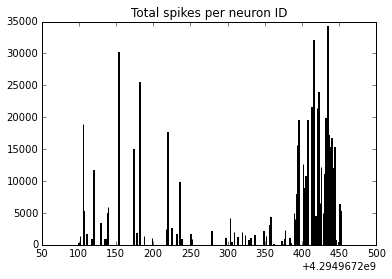

In [3]:
import collections
counter=collections.Counter(data[0])

# a histogram of total number of spikes
plt.bar(counter.keys(),counter.values())
plt.title('Total spikes per neuron ID') 

## Duration

In [4]:
metadata = h5py.File('20150314_datafile001_76_mn_metadata.mat', 'r')
samplingHz = metadata['metadata/rt'][0][0]
numSamples = metadata['metadata/numSamples'][0][0]
duration = numSamples / samplingHz

print "Duration of the experiment: " + str(duration) + " seconds = " + \
    str(duration / 60) + " minutes"

Duration of the experiment: 4560.0 seconds = 76.0 minutes


## Conditions

In [5]:
file = h5py.File('trialData.mat', 'r')
UOIs = file['trialDataStruct/UOIs'][0]
odorEpochs = file['trialDataStruct/odorEpochs']
valveID = file['trialDataStruct/valveID']
numTrials = file['trialDataStruct/numTrials'][0][0]
conditions = ["Isoamyl Acetate", "Limonene", "Pinene", "Benzaldehyde", "Acetophenone", "Octanal", "BLANK", "Hexenol"]

n = 0
for id in valveID:
    print "Trial " + str(n) + " (" + conditions[int(id)] + ") begins at time " + str(odorEpochs[0][n]) + " and ends at time " + str(odorEpochs[1][n])
    n += 1
    if (n > 10): 
        print "..." 
        break

Trial 0 (Limonene) begins at time 2796731.0 and ends at time 2916762.0
Trial 1 (Octanal) begins at time 3704597.0 and ends at time 3824627.0
Trial 2 (Acetophenone) begins at time 5612789.0 and ends at time 5732879.0
Trial 3 (BLANK) begins at time 6848856.0 and ends at time 6969067.0
Trial 4 (Benzaldehyde) begins at time 7780842.0 and ends at time 7900872.0
Trial 5 (Hexenol) begins at time 8849508.0 and ends at time 8969539.0
Trial 6 (Pinene) begins at time 9770694.0 and ends at time 9890725.0
Trial 7 (Isoamyl Acetate) begins at time 10904011.0 and ends at time 11024042.0
Trial 8 (Limonene) begins at time 11972078.0 and ends at time 12092108.0
Trial 9 (Octanal) begins at time 12893743.0 and ends at time 13013774.0
Trial 10 (Hexenol) begins at time 13812529.0 and ends at time 13932560.0
...


We can use the above trial / condition parameters to calculate a firing Z-score over all trials, see picture at top.

# Analysis (naive)

In short, let's throw a bunch of out-of-the-box algorithms at the data.

First, to apply topological data analysis (TDA), we need to convert the spike train data into some sort of point cloud representation. Below is a simple demonstration of the persistent homology of generated point cloud data, in this case a sphere.

In [6]:
# (2/21) Attempted to setup the Dionysus persistent homology package, but received a consistent error `Fatal Python error: PyEval_SaveThread: NULL tstate`. I believe this has to do with the Python bindings.
# (2/22) Attempted to use the Holes package (a port of javaPlex, after which I will default to using Plex in Matlab), but there's no documentation for it.
# (2/23) Skipping to Python Mapper, attempting on GUI before importing it as a Python module.

My first thought would be to represent the data in a 68-dimension vector space $V$ where each axis represents the "time" for that neuron; for every axis $i$ and at every time point $t$, we draw a point at $(0, ..., 0,t,0,..., 0)$ (where $t$ is in the $i$-th position) if neuron $i$ fires at time $t$. If two neurons $k_i$ and $k_j$ fire at the same time, we draw a point at $(0,...,t,...,t,...,0)$ where $t$ is in the $i$-th and $j$-th positions. But given the shape of the data (long and stretched out) it might be quite difficult to get any kind of interesting topological structure out of this data representation.

What do we normally do? There's no behavior condition here (as there is in Resource #2) so we can't apply a (supervised) learning algorithm. PCA involves representing the variance of each neuron across the 8 odorants and slicing off neurons "that contribute less" (I think? please correct me if this isn't what you guys do). Below we run naive PCA on the data.

In [6]:
# compare to computed eigenvalues at "20150205-datafile002_eigenvalues.fig"
from scipy.io import loadmat
x = loadmat('20150205-datafile002_eigenvalues.fig')

# compare to projection onto first 3 principal components at "20150205-datafile002_projection.fig"

In this case we note that PCA does not look at the co-firing information. If there's any topological information in the data I'd guess it would be embedded in the co-firing patterns.

Below is a variant of PCA tailored to spike train analysis called [GPFA](http://users.ece.cmu.edu/~byronyu/software.shtml).

In [1]:
# GPFA code / Matlab pictures here ... but don't have a copy of Matlab.

Lastly we run SVM.

In [ ]:
# SVM code here
# import scipy.svm

# Analysis continued

As an exercise, let's try to reproduce the experiment and analysis in Dabaghian et al.

1. Simulate spike data.
    1. Construct the rate model by representing place cell firing as an inhomogeneous Poisson process with a time-independent rate function $\lambda (\vec{r})$ in terms of the animal's position, $\vec r$. This gives us stochastic firing around the place field centers. For a place cell $c_i$ modeled under a simple 2d Gaussian, \begin{equation}\lambda_i (\vec r) = f_i \exp \left (-\frac{(r -r^c_i)^2}{2s_i^2} \right),\end{equation} where $r_i^c$ is the center of the $i$th place field and $s_i^2$ is the variance.
    2. As the rat moves around the room, its place cells fire following $\lambda_i(\vec r)$. We convert this into a string $s_i$ of firing times.
2. Construct simplicial complex from spike data.
    1. It's worth remembering: the **physical room** is the "underlying space" $X$ (which is being covered / modelled by the place field simplicial complex $\mathcal{PF}$.
    2. We want to infer the "place field simplicial complex" $\mathcal{PF}$ (which may be constructed, in the obvious way, if we knew the shapes and locations of the place fields) by the "temporal spike train simplicial complex" $\mathcal{T}$.
    3. Idea: take co-firing of place cells at same time $c_i, c_j, c_k, ...$ as evidence of overlap of place fields $PF_i, PF_j, PF_k$.
    4. Take spike train data $s_1, ..., s_N$ associated to $N$ cells, where each $s_i$ is a list of the times that the cell $c_i$ fires. 
    5. Fix $\epsilon >0$ and $m \in \mathbb{N}$. Define $\mathcal{T}$ as the simplicial complex with simplices given by the rule \begin{equation}[i_1, i_2, ..., i_k] \in \mathcal{T} \Leftrightarrow \exists t \in [0,T] \text{ such that } \min_{j \in \{1, ..., k\}} \left | s_{i_j} \cap [t-\epsilon, t+\epsilon] \right | \geq m. \end{equation} So this a sort of threshold requirement: $m$ is the mininum number of times that *all* the place cells $c_{i_1}, ..., c_{i_k}$ fire in the window $[t-\epsilon,t+\epsilon]$.
3. Construct filtration based on simplicial complex.
    1. Construct a filtration on the complex $\mathcal{T}$ by a function $\textbf{f} : \mathcal{T} \to \mathbb{R}^+$: \begin{equation}\textbf{f}([i_1, ..., i_k]) = \min \left \{ t \in [0,T] : \min_{j \in \{1, ..., k\}} \left | s_{i_j} \cap [t-\epsilon, t+\epsilon] \right | \geq m \right \}\end{equation} This filtration is a sequence of nested simplicial complexes built across time. To verify that this is in fact a filtration parameterized by the real variable $t \in \mathbb{R}^+$, note that any simplex $\sigma$ containing $i$ satisfies $\textbf{f}(\sigma) \geq \textbf{f}(i)$.
    2. So we can define a sequence of simplicial complexes $\mathcal{T}(t_1) \subset ... \subset \mathcal{T}(t_n) = \mathcal{T}$ given by \begin{equation}T(t) = \{ \sigma \in \mathcal{T}: \textbf{f}(\sigma) \leq t\}.\end{equation} 
    3. We can apply persistent homology directly on the filtration.
4. Compute.
    1. Use PLEX in Matlab.

Second exercise: reproduce the experiment and analysis in Singh et al.

1. Generate simulated data.
    1. Take a population of $N$ cells with homogeneous tuning curves (???) and preferred orientations (18 total) equalled spaced around the circle. So an orientation cell $c_i$ will fire when presented with an image that has that particular orientation. Give 100 presentations per orientation. It fires stochastically, according to some tuning curve $\lambda(\theta, \phi)$ so that mean spikes per bin satisfy a Poisson distribution.
    2. The data is stored as a data matrix $X$, with rows representing single presentations of orientations (so 1800 rows) and columns the cells $c_1, ..., c_N$.
2. Preprocess macaque visual cortex data.
    1. 
2. Construct simplicial complex from spike data.
    1. Recall definition of a Rips complex: fix parameter $\epsilon$, draw a path beween all points for which $d(x,y) < \epsilon$, a 2-simplex between (x,y,z) if all pairwise distances are less than $\epsilon$, and so on.
    1. Take a finite set of points $X$ (the 
3. Construct filtration based on simplicial complex.
4. Compute.

The key fact (and difference) is that Dabaghian et. al. are using persistent homology not only as a pure data analytics tool but as part of a *biological hypothesis* about how the place cells work. That is, they conjecture that the neurons downstream of the place cells interpret the co-firing of place cells as *natively topological* information---information about connectedness, adjacency, and containment---rather than exact geometric information about distances. They suggest that the actual neural mechanism for interpreting these co-firings could be something like persistent homology.

Also, in their experiment they are generating the simplicial complex directly, not forming a cover over points in a metric space.

In our case we have no idea what the "true topology" of the odorant would be; we have only a minimal representation of that odorant in terms of the neuron firings.

A normal approach to time series: decompose into Fourier basis, so each spike train gets decomposed as a linear combination of Fourier elements.

Another approach would be to use the "vineyard" approach discussed in [Applying Persistent Homology to Time Varying Systems](http://www.elizabethmunch.com/math/research/ElizabethMunch-TimeVaryingPersistence.pdf). In her thesis, Munch describes methods for combining many "slices" of the persistent homology of a point cloud as it varies (continuously).